In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# hyperparameters = {
#         "learning_rate": 0.00005,
#         "epochs": 100,
#         "batch_size": 10,
# }

In [4]:
MLP_model = [
    tf.keras.layers.Flatten(input_shape=(60, 100)),
    # tf.keras.layers.Flatten(input_shape=(60, 400)),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),


    tf.keras.layers.Dense(5),
    tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Softmax()
]

In [5]:
# step 0. Check GPUs available:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
# set device
device = tf.device('/GPU:0') if len(gpus) != 0 else tf.device('/CPU:0')

Num GPUs Available: 1
Metal device set to: Apple M1 Pro


In [6]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up"):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
    # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
    data_label_np = np.array([data_json["new_label"]])
    # data_label_np = np.array([data_json["layers_num"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|██████████████████████| 100/100 [00:00<00:00, 821.82it/s]


In [7]:
array = np.array(train_dataset.data_inputs)

In [8]:
np.unique(array)

array([-15.,   1.,   2.,   3.,   4.,   5.,   6.])

In [9]:
# x=810
# array[x:x+100]

In [10]:
# step 2. build model
model = tf.keras.Sequential(MLP_model)

# step 3. define loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # step 4. Model compile
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hyperparameters['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# step 5. select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
# step 6. train & evaluate & save model
losses_train, accuracy_train, losses_test, accuracy_test, model = function_training.train_it(device, model, "./state_dicts/",
                                                                                      hyperparameters['epochs'],train_loader, test_loader, loss_fn, optimizer,
                                                                                      train_loss, train_accuracy, test_loss, test_accuracy,
                                                                                      eval_num_epochs=1, numClasss=args["load"]["numClasses"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             60010000  
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3125)              31253125  
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3125)              0

2022-03-17 10:05:57.904190: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 | Loss:   1.704849123954773 | Accuracy (%):   35.222225189208984
	Test Loss:  1.3527538776397705  |  Test Accuracy (%): 41.0
Epoch 2 | Loss:   1.3628257513046265 | Accuracy (%):   45.77777862548828
	Test Loss:  1.430095911026001  |  Test Accuracy (%): 48.999996185302734
Epoch 3 | Loss:   1.341951847076416 | Accuracy (%):   46.111114501953125
	Test Loss:  1.2114588022232056  |  Test Accuracy (%): 51.0
Epoch 4 | Loss:   1.2809356451034546 | Accuracy (%):   50.0
	Test Loss:  1.3414909839630127  |  Test Accuracy (%): 42.999996185302734
Epoch 5 | Loss:   1.2239868640899658 | Accuracy (%):   51.0
	Test Loss:  1.427132248878479  |  Test Accuracy (%): 48.999996185302734
Epoch 6 | Loss:   1.2324267625808716 | Accuracy (%):   53.333335876464844
	Test Loss:  1.106359839439392  |  Test Accuracy (%): 48.999996185302734
Epoch 7 | Loss:   1.2269351482391357 | Accuracy (%):   52.66667175292969
	Test Loss:  1.1698499917984009  |  Test Accuracy (%): 52.999996185302734
Epoch 8 | Loss:   1.1799223

Epoch 61 | Loss:   0.9056952595710754 | Accuracy (%):   68.33333587646484
	Test Loss:  1.1226497888565063  |  Test Accuracy (%): 59.999996185302734
Epoch 62 | Loss:   0.8878849148750305 | Accuracy (%):   66.0
	Test Loss:  1.2297046184539795  |  Test Accuracy (%): 53.999996185302734
Epoch 63 | Loss:   0.8561189770698547 | Accuracy (%):   66.44444274902344
	Test Loss:  1.146740436553955  |  Test Accuracy (%): 57.0
Epoch 64 | Loss:   0.8653927445411682 | Accuracy (%):   67.22222900390625
	Test Loss:  1.2995091676712036  |  Test Accuracy (%): 56.0
Epoch 65 | Loss:   0.8337088823318481 | Accuracy (%):   67.55555725097656
	Test Loss:  1.0626566410064697  |  Test Accuracy (%): 59.999996185302734
Epoch 66 | Loss:   0.8405870199203491 | Accuracy (%):   66.11111450195312
	Test Loss:  1.390350341796875  |  Test Accuracy (%): 59.999996185302734
Epoch 67 | Loss:   0.8030949831008911 | Accuracy (%):   66.22222900390625
	Test Loss:  1.1601191759109497  |  Test Accuracy (%): 58.999996185302734
Epoch 6

Epoch 121 | Loss:   0.719799816608429 | Accuracy (%):   72.22222900390625
	Test Loss:  1.1288681030273438  |  Test Accuracy (%): 57.0
Epoch 122 | Loss:   0.7449947595596313 | Accuracy (%):   70.77777862548828
	Test Loss:  1.1044011116027832  |  Test Accuracy (%): 58.999996185302734
Epoch 123 | Loss:   0.7195429801940918 | Accuracy (%):   70.66667175292969
	Test Loss:  1.2933090925216675  |  Test Accuracy (%): 59.999996185302734
Epoch 124 | Loss:   0.6781049370765686 | Accuracy (%):   72.11111450195312
	Test Loss:  1.403509259223938  |  Test Accuracy (%): 58.0
Epoch 125 | Loss:   0.6852108240127563 | Accuracy (%):   71.66667175292969
	Test Loss:  1.006050705909729  |  Test Accuracy (%): 52.999996185302734
Epoch 126 | Loss:   0.6953656673431396 | Accuracy (%):   72.8888931274414
	Test Loss:  1.6457784175872803  |  Test Accuracy (%): 58.0
Epoch 127 | Loss:   0.7252708673477173 | Accuracy (%):   71.55555725097656
	Test Loss:  1.2270246744155884  |  Test Accuracy (%): 58.0
Epoch 128 | Loss:

Epoch 181 | Loss:   0.6420153379440308 | Accuracy (%):   76.0
	Test Loss:  1.3699774742126465  |  Test Accuracy (%): 53.999996185302734
Epoch 182 | Loss:   0.6073766946792603 | Accuracy (%):   76.0
	Test Loss:  1.3189723491668701  |  Test Accuracy (%): 58.0
Epoch 183 | Loss:   0.5729261040687561 | Accuracy (%):   76.22222137451172
	Test Loss:  1.3518357276916504  |  Test Accuracy (%): 58.999996185302734
Epoch 184 | Loss:   0.6223377585411072 | Accuracy (%):   75.55555725097656
	Test Loss:  1.3598873615264893  |  Test Accuracy (%): 53.999996185302734
Epoch 185 | Loss:   0.6246273517608643 | Accuracy (%):   76.66667175292969
	Test Loss:  1.0715001821517944  |  Test Accuracy (%): 58.0
Epoch 186 | Loss:   0.607826828956604 | Accuracy (%):   76.88888549804688
	Test Loss:  1.1665589809417725  |  Test Accuracy (%): 56.0
Epoch 187 | Loss:   0.5804725289344788 | Accuracy (%):   78.0
	Test Loss:  1.2481380701065063  |  Test Accuracy (%): 61.0
Epoch 188 | Loss:   0.5823908448219299 | Accuracy (%)

Epoch 240 | Loss:   0.5652673244476318 | Accuracy (%):   78.66667175292969
	Test Loss:  1.280613660812378  |  Test Accuracy (%): 52.999996185302734
Epoch 241 | Loss:   0.5543800592422485 | Accuracy (%):   77.33333587646484
	Test Loss:  1.2532875537872314  |  Test Accuracy (%): 58.0
Epoch 242 | Loss:   0.5495985150337219 | Accuracy (%):   79.66667175292969
	Test Loss:  1.2334606647491455  |  Test Accuracy (%): 57.0
Epoch 243 | Loss:   0.5332271456718445 | Accuracy (%):   81.0
	Test Loss:  1.197409749031067  |  Test Accuracy (%): 57.0
Epoch 244 | Loss:   0.5492550730705261 | Accuracy (%):   79.55555725097656
	Test Loss:  1.503405213356018  |  Test Accuracy (%): 55.0
Epoch 245 | Loss:   0.5176772475242615 | Accuracy (%):   78.66667175292969
	Test Loss:  1.0152521133422852  |  Test Accuracy (%): 56.0
Epoch 246 | Loss:   0.5406417846679688 | Accuracy (%):   78.33333587646484
	Test Loss:  1.5165667533874512  |  Test Accuracy (%): 58.999996185302734
Epoch 247 | Loss:   0.5191821455955505 | Ac

Epoch 300 | Loss:   0.47301870584487915 | Accuracy (%):   81.0
	Test Loss:  1.4728524684906006  |  Test Accuracy (%): 57.0
Epoch 301 | Loss:   0.4421721398830414 | Accuracy (%):   82.44445037841797
	Test Loss:  1.5641554594039917  |  Test Accuracy (%): 57.0
Epoch 302 | Loss:   0.4609147310256958 | Accuracy (%):   82.11111450195312
	Test Loss:  1.175417184829712  |  Test Accuracy (%): 59.999996185302734
Epoch 303 | Loss:   0.4492785334587097 | Accuracy (%):   82.33333587646484
	Test Loss:  1.2399686574935913  |  Test Accuracy (%): 58.0
Epoch 304 | Loss:   0.46315789222717285 | Accuracy (%):   82.66667175292969
	Test Loss:  1.6251728534698486  |  Test Accuracy (%): 58.0
Epoch 305 | Loss:   0.4826161861419678 | Accuracy (%):   80.66666412353516
	Test Loss:  1.1431251764297485  |  Test Accuracy (%): 56.0
Epoch 306 | Loss:   0.5085472464561462 | Accuracy (%):   81.0
	Test Loss:  1.4638910293579102  |  Test Accuracy (%): 61.0
Epoch 307 | Loss:   0.4934864342212677 | Accuracy (%):   81.333335

Epoch 359 | Loss:   0.4019017815589905 | Accuracy (%):   84.0
	Test Loss:  1.6083219051361084  |  Test Accuracy (%): 56.0
Epoch 360 | Loss:   0.3784686326980591 | Accuracy (%):   85.77777862548828
	Test Loss:  1.6454490423202515  |  Test Accuracy (%): 56.0
Epoch 361 | Loss:   0.43844136595726013 | Accuracy (%):   83.77777862548828
	Test Loss:  1.2434042692184448  |  Test Accuracy (%): 53.999996185302734
Epoch 362 | Loss:   0.4265057146549225 | Accuracy (%):   83.55555725097656
	Test Loss:  1.4226863384246826  |  Test Accuracy (%): 52.0
Epoch 363 | Loss:   0.42953550815582275 | Accuracy (%):   84.44444274902344
	Test Loss:  2.161956787109375  |  Test Accuracy (%): 58.0
Epoch 364 | Loss:   0.40684136748313904 | Accuracy (%):   84.33333587646484
	Test Loss:  1.170805811882019  |  Test Accuracy (%): 52.999996185302734
Epoch 365 | Loss:   0.44010260701179504 | Accuracy (%):   84.66667175292969
	Test Loss:  1.4119138717651367  |  Test Accuracy (%): 56.0
Epoch 366 | Loss:   0.4220270812511444

Epoch 419 | Loss:   0.46071162819862366 | Accuracy (%):   83.77777862548828
	Test Loss:  1.2651201486587524  |  Test Accuracy (%): 52.999996185302734
Epoch 420 | Loss:   0.5123782753944397 | Accuracy (%):   81.11111450195312
	Test Loss:  1.1917808055877686  |  Test Accuracy (%): 57.0
Epoch 421 | Loss:   0.46234190464019775 | Accuracy (%):   85.0
	Test Loss:  1.7708420753479004  |  Test Accuracy (%): 53.999996185302734
Epoch 422 | Loss:   0.44692349433898926 | Accuracy (%):   82.11111450195312
	Test Loss:  1.5981509685516357  |  Test Accuracy (%): 52.999996185302734
Epoch 423 | Loss:   0.4069473445415497 | Accuracy (%):   83.77777862548828
	Test Loss:  1.2886974811553955  |  Test Accuracy (%): 55.0
Epoch 424 | Loss:   0.43975114822387695 | Accuracy (%):   85.55555725097656
	Test Loss:  1.8072218894958496  |  Test Accuracy (%): 55.0
Epoch 425 | Loss:   0.4072601795196533 | Accuracy (%):   85.11111450195312
	Test Loss:  1.2636823654174805  |  Test Accuracy (%): 53.999996185302734
Epoch 42

Epoch 479 | Loss:   0.3406773805618286 | Accuracy (%):   86.44445037841797
	Test Loss:  1.6542251110076904  |  Test Accuracy (%): 58.0
Epoch 480 | Loss:   0.32261592149734497 | Accuracy (%):   86.8888931274414
	Test Loss:  1.5990242958068848  |  Test Accuracy (%): 56.0
Epoch 481 | Loss:   0.34431689977645874 | Accuracy (%):   86.66666412353516
	Test Loss:  1.6505506038665771  |  Test Accuracy (%): 56.0
Epoch 482 | Loss:   0.34060752391815186 | Accuracy (%):   85.44444274902344
	Test Loss:  1.852719783782959  |  Test Accuracy (%): 56.0
Epoch 483 | Loss:   0.4136202335357666 | Accuracy (%):   87.11111450195312
	Test Loss:  1.44003164768219  |  Test Accuracy (%): 56.0
Epoch 484 | Loss:   0.37099114060401917 | Accuracy (%):   86.8888931274414
	Test Loss:  1.436842679977417  |  Test Accuracy (%): 61.0
Epoch 485 | Loss:   0.34199172258377075 | Accuracy (%):   86.8888931274414
	Test Loss:  1.8619227409362793  |  Test Accuracy (%): 57.0
Epoch 486 | Loss:   0.351706326007843 | Accuracy (%):   8

Epoch 539 | Loss:   0.3175794780254364 | Accuracy (%):   88.44445037841797
	Test Loss:  1.9994757175445557  |  Test Accuracy (%): 55.0
Epoch 540 | Loss:   0.33722594380378723 | Accuracy (%):   88.77777862548828
	Test Loss:  1.3478343486785889  |  Test Accuracy (%): 59.999996185302734
Epoch 541 | Loss:   0.3509816527366638 | Accuracy (%):   85.55555725097656
	Test Loss:  1.3472859859466553  |  Test Accuracy (%): 58.0
Epoch 542 | Loss:   0.2977001667022705 | Accuracy (%):   89.00000762939453
	Test Loss:  1.3251571655273438  |  Test Accuracy (%): 55.0
Epoch 543 | Loss:   0.3072064518928528 | Accuracy (%):   89.22222137451172
	Test Loss:  1.4630053043365479  |  Test Accuracy (%): 52.0
Epoch 544 | Loss:   0.3399108648300171 | Accuracy (%):   87.11111450195312
	Test Loss:  1.7156620025634766  |  Test Accuracy (%): 58.0
Epoch 545 | Loss:   0.34857919812202454 | Accuracy (%):   87.11111450195312
	Test Loss:  1.8099358081817627  |  Test Accuracy (%): 57.0
Epoch 546 | Loss:   0.3101924955844879 

Epoch 599 | Loss:   0.3010755777359009 | Accuracy (%):   89.66667175292969
	Test Loss:  1.506485104560852  |  Test Accuracy (%): 58.0
Epoch 600 | Loss:   0.3298116624355316 | Accuracy (%):   87.11111450195312
	Test Loss:  1.745971441268921  |  Test Accuracy (%): 56.0
Epoch 601 | Loss:   0.32808420062065125 | Accuracy (%):   88.0
	Test Loss:  1.7479593753814697  |  Test Accuracy (%): 56.0
Epoch 602 | Loss:   0.3441058397293091 | Accuracy (%):   86.44445037841797
	Test Loss:  1.4874874353408813  |  Test Accuracy (%): 57.0
Epoch 603 | Loss:   0.29992687702178955 | Accuracy (%):   89.22222137451172
	Test Loss:  1.5807592868804932  |  Test Accuracy (%): 52.999996185302734
Epoch 604 | Loss:   0.34155526757240295 | Accuracy (%):   86.22222900390625
	Test Loss:  1.5192222595214844  |  Test Accuracy (%): 57.0
Epoch 605 | Loss:   0.29950547218322754 | Accuracy (%):   89.22222137451172
	Test Loss:  1.4898343086242676  |  Test Accuracy (%): 58.0
Epoch 606 | Loss:   0.28917649388313293 | Accuracy (

Epoch 659 | Loss:   0.26400595903396606 | Accuracy (%):   89.88888549804688
	Test Loss:  1.5026922225952148  |  Test Accuracy (%): 51.0
Epoch 660 | Loss:   0.266685426235199 | Accuracy (%):   90.0
	Test Loss:  1.9416842460632324  |  Test Accuracy (%): 58.999996185302734
Epoch 661 | Loss:   0.3064292371273041 | Accuracy (%):   89.66667175292969
	Test Loss:  1.5868663787841797  |  Test Accuracy (%): 56.0
Epoch 662 | Loss:   0.31833526492118835 | Accuracy (%):   86.77778625488281
	Test Loss:  1.4387683868408203  |  Test Accuracy (%): 52.999996185302734
Epoch 663 | Loss:   0.26732513308525085 | Accuracy (%):   90.44444274902344
	Test Loss:  1.9538503885269165  |  Test Accuracy (%): 55.0
Epoch 664 | Loss:   0.2584666311740875 | Accuracy (%):   90.44444274902344
	Test Loss:  1.9344013929367065  |  Test Accuracy (%): 50.0
Epoch 665 | Loss:   0.28376534581184387 | Accuracy (%):   89.66667175292969
	Test Loss:  1.4133087396621704  |  Test Accuracy (%): 61.0
Epoch 666 | Loss:   0.273859620094299

Epoch 719 | Loss:   0.29497218132019043 | Accuracy (%):   90.0
	Test Loss:  1.9069197177886963  |  Test Accuracy (%): 52.999996185302734
Epoch 720 | Loss:   0.30979323387145996 | Accuracy (%):   87.33333587646484
	Test Loss:  1.4182337522506714  |  Test Accuracy (%): 58.0
Epoch 721 | Loss:   0.3024139106273651 | Accuracy (%):   89.33333587646484
	Test Loss:  2.137791156768799  |  Test Accuracy (%): 56.0
Epoch 722 | Loss:   0.3454647660255432 | Accuracy (%):   88.0
	Test Loss:  1.678565502166748  |  Test Accuracy (%): 53.999996185302734
Epoch 723 | Loss:   0.2670799195766449 | Accuracy (%):   89.44444274902344
	Test Loss:  1.5663083791732788  |  Test Accuracy (%): 50.0
Epoch 724 | Loss:   0.25904175639152527 | Accuracy (%):   89.66667175292969
	Test Loss:  1.6029984951019287  |  Test Accuracy (%): 55.0
Epoch 725 | Loss:   0.23989948630332947 | Accuracy (%):   90.55555725097656
	Test Loss:  1.473834753036499  |  Test Accuracy (%): 57.0
Epoch 726 | Loss:   0.24911954998970032 | Accuracy (

Epoch 778 | Loss:   0.23886455595493317 | Accuracy (%):   90.33333587646484
	Test Loss:  2.365274667739868  |  Test Accuracy (%): 52.0
Epoch 779 | Loss:   0.23950068652629852 | Accuracy (%):   90.77777862548828
	Test Loss:  2.0096185207366943  |  Test Accuracy (%): 52.999996185302734
Epoch 780 | Loss:   0.27499502897262573 | Accuracy (%):   90.55555725097656
	Test Loss:  2.517296314239502  |  Test Accuracy (%): 58.999996185302734
Epoch 781 | Loss:   0.3071955442428589 | Accuracy (%):   88.22222137451172
	Test Loss:  1.7030385732650757  |  Test Accuracy (%): 48.999996185302734
Epoch 782 | Loss:   0.2560725510120392 | Accuracy (%):   89.44444274902344
	Test Loss:  1.5831986665725708  |  Test Accuracy (%): 53.999996185302734
Epoch 783 | Loss:   0.2378123253583908 | Accuracy (%):   91.55555725097656
	Test Loss:  1.5462169647216797  |  Test Accuracy (%): 56.0
Epoch 784 | Loss:   0.2563537359237671 | Accuracy (%):   90.66667175292969
	Test Loss:  1.8524858951568604  |  Test Accuracy (%): 55.

Epoch 838 | Loss:   0.23151959478855133 | Accuracy (%):   90.8888931274414
	Test Loss:  1.8142279386520386  |  Test Accuracy (%): 53.999996185302734
Epoch 839 | Loss:   0.22264628112316132 | Accuracy (%):   90.8888931274414
	Test Loss:  1.6795064210891724  |  Test Accuracy (%): 52.999996185302734
Epoch 840 | Loss:   0.28411170840263367 | Accuracy (%):   91.0
	Test Loss:  2.6868863105773926  |  Test Accuracy (%): 53.999996185302734
Epoch 841 | Loss:   0.2566365897655487 | Accuracy (%):   90.55555725097656
	Test Loss:  1.9880348443984985  |  Test Accuracy (%): 48.0
Epoch 842 | Loss:   0.22240012884140015 | Accuracy (%):   90.55555725097656
	Test Loss:  2.0900726318359375  |  Test Accuracy (%): 56.0
Epoch 843 | Loss:   0.22617894411087036 | Accuracy (%):   92.33333587646484
	Test Loss:  1.8335144519805908  |  Test Accuracy (%): 52.0
Epoch 844 | Loss:   0.211708202958107 | Accuracy (%):   92.77778625488281
	Test Loss:  1.5860049724578857  |  Test Accuracy (%): 58.999996185302734
Epoch 845 

Epoch 897 | Loss:   0.18796108663082123 | Accuracy (%):   91.55555725097656
	Test Loss:  2.283473491668701  |  Test Accuracy (%): 51.0
Epoch 898 | Loss:   0.19958172738552094 | Accuracy (%):   92.33333587646484
	Test Loss:  1.8420264720916748  |  Test Accuracy (%): 51.0
Epoch 899 | Loss:   0.23130851984024048 | Accuracy (%):   91.44444274902344
	Test Loss:  1.7800503969192505  |  Test Accuracy (%): 57.0
Epoch 900 | Loss:   0.2376987338066101 | Accuracy (%):   91.77777862548828
	Test Loss:  2.4937167167663574  |  Test Accuracy (%): 58.0
Epoch 901 | Loss:   0.19536755979061127 | Accuracy (%):   93.11111450195312
	Test Loss:  2.60699725151062  |  Test Accuracy (%): 56.0
Epoch 902 | Loss:   0.2111753225326538 | Accuracy (%):   92.22222900390625
	Test Loss:  1.8027442693710327  |  Test Accuracy (%): 52.999996185302734
Epoch 903 | Loss:   0.23181813955307007 | Accuracy (%):   92.0
	Test Loss:  1.669895887374878  |  Test Accuracy (%): 55.0
Epoch 904 | Loss:   0.21045972406864166 | Accuracy (%

Epoch 957 | Loss:   0.1988825798034668 | Accuracy (%):   92.55555725097656
	Test Loss:  2.233219623565674  |  Test Accuracy (%): 57.0
Epoch 958 | Loss:   0.21943023800849915 | Accuracy (%):   91.44444274902344
	Test Loss:  1.6367660760879517  |  Test Accuracy (%): 58.0
Epoch 959 | Loss:   0.19239500164985657 | Accuracy (%):   93.11111450195312
	Test Loss:  2.2610907554626465  |  Test Accuracy (%): 57.0
Epoch 960 | Loss:   0.1925739198923111 | Accuracy (%):   91.8888931274414
	Test Loss:  1.8640367984771729  |  Test Accuracy (%): 57.0
Epoch 961 | Loss:   0.20166507363319397 | Accuracy (%):   91.66667175292969
	Test Loss:  2.252908945083618  |  Test Accuracy (%): 55.0
Epoch 962 | Loss:   0.19384685158729553 | Accuracy (%):   92.33333587646484
	Test Loss:  1.7706302404403687  |  Test Accuracy (%): 57.0
Epoch 963 | Loss:   0.268014520406723 | Accuracy (%):   93.0
	Test Loss:  1.8109232187271118  |  Test Accuracy (%): 57.0
Epoch 964 | Loss:   0.21138903498649597 | Accuracy (%):   93.2222213

2022-03-17 10:25:40.719127: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./state_dicts/assets


In [12]:
# for test_x, test_labels in test_loader:
#     print (f"model {model(test_x,training=False)}, actual {test_labels}")

In [13]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    figure = plt.figure(figsize=(8, 8), dpi=400)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
#     plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
#     plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)


    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Prediction')
#     return figure

In [14]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])
    predict = np.argmax(model.predict(element), axis=-1)
    label = np.array(labels).flatten()
#     print (f"model {model.predict_classes(element)}, actual {labels}")
#     model.predict_classes(element)
    break


In [15]:
cm = np.array(tf.math.confusion_matrix(labels=label, predictions=predict))

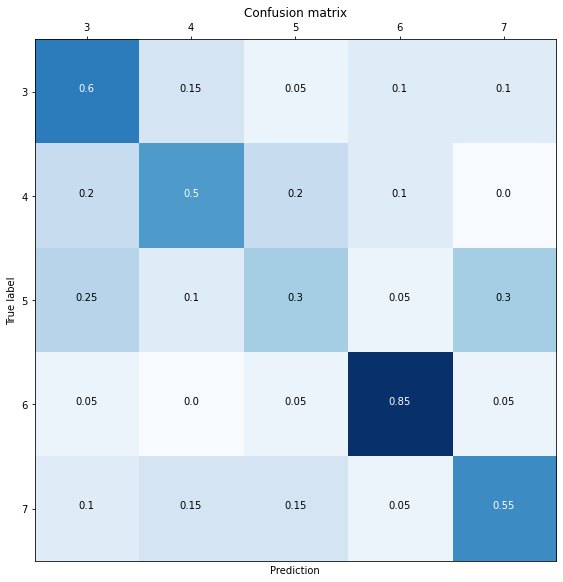

In [16]:
plot_confusion_matrix(cm, [3, 4, 5, 6, 7])